<a href="https://colab.research.google.com/github/frasilva82/Trabalho-MVP-ML-PUC/blob/main/MVP_PUC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## MVP: Machine Learning & Analytics
## Autor: Francisco Almeida da Silva
## Data: 27/09/2025
## Matrícula: 4052025001516

Dataset: https://raw.githubusercontent.com/frasilva82/Trabalho-MVP-ML-PUC/refs/heads/main/jornada_do_cliente.csv

Resumo:

Este trabalho apresenta o desenvolvimento de um MVP de Machine Learning com o objetivo de prever o grau de satisfação/recomendação dos clientes na pesquisa de NPS realizada seis meses após a entrega das chaves (C+6). A base de dados contemplou informações coletadas na vistoria, perfil socioeconômico e registros da assistência técnica. Foram testados diferentes algoritmos de classificação, desde modelos lineares até técnicas de ensemble e boosting, com uso de pipelines e validação cruzada. O baseline (Dummy Classifier) obteve 48% de acurácia, enquanto os melhores resultados foram alcançados pelos modelos de boosting (AdaBoost e Gradient Boosting), com acurácia média próxima a 58%. A otimização de hiperparâmetros trouxe ganhos limitados, mas confirmou a relevância do boosting para o problema. A análise destacou como principal desafio a correta classificação dos clientes Neutros, devido ao desbalanceamento das classes. Por fim, foram realizadas simulações práticas com clientes fictícios, demonstrando como o modelo pode apoiar decisões de negócio na gestão da experiência do cliente.


##1) Análise Exploratória dos Dados (EDA)

A primeira etapa consistiu em compreender a estrutura e a qualidade da base de dados. Foram avaliadas as distribuições da variável alvo (nps_6m_target), a frequência das categorias de variáveis qualitativas e a presença de valores ausentes. Essa análise exploratória é fundamental para identificar eventuais desbalanceamentos entre classes e problemas de preenchimento que possam impactar a modelagem.



Dimensão da base: (2539, 15)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2539 entries, 0 to 2538
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   numero_cliente            2539 non-null   int64  
 1   regional                  2539 non-null   object 
 2   safra_inicio_obras        2539 non-null   object 
 3   nps_vistoria              2539 non-null   object 
 4   faixa_renda               2539 non-null   object 
 5   idade                     2527 non-null   float64
 6   filhos                    2527 non-null   float64
 7   sexo                      2527 non-null   float64
 8   estado_civil              2539 non-null   object 
 9   escolaridade              2539 non-null   object 
 10  meses_para_entrega        2539 non-null   int64  
 11  status_assistencia        2539 non-null   object 
 12  acionamentos_assistencia  2527 non-null   float64
 13  nps_6m                    2539 non

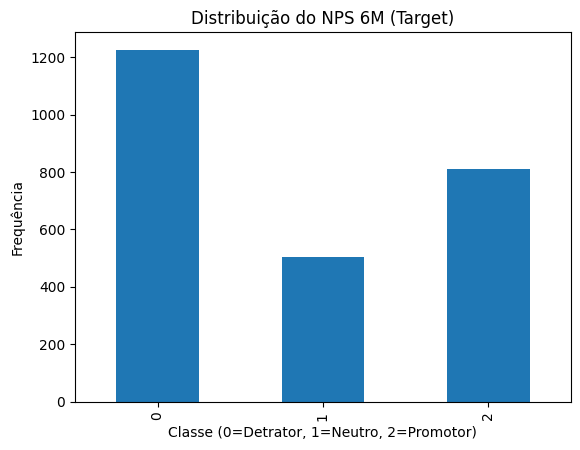


Percentual de valores ausentes:
numero_cliente              0.00
regional                    0.00
safra_inicio_obras          0.00
nps_vistoria                0.00
faixa_renda                 0.00
idade                       0.47
filhos                      0.47
sexo                        0.47
estado_civil                0.00
escolaridade                0.00
meses_para_entrega          0.00
status_assistencia          0.00
acionamentos_assistencia    0.47
nps_6m                      0.00
nps_6m_target               0.00
dtype: float64


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) Ler a base direto do GitHub (delimitador ; )
url = "https://raw.githubusercontent.com/frasilva82/Trabalho-MVP-ML-PUC/refs/heads/main/jornada_do_cliente.csv"
df = pd.read_csv(url, sep=";", encoding="utf-8-sig")

# 2) Criar coluna de target numérico se não existir
if "nps_6m_target" not in df.columns and "nps_6m" in df.columns:
    map_target = {"Detrator": 0, "Neutro": 1, "Promotor": 2,
                  "DETRATOR": 0, "NEUTRO": 1, "PROMOTOR": 2}
    df["nps_6m_target"] = df["nps_6m"].map(map_target)

# 3) Ajustar colunas numéricas para o tipo correto
num_cols = ["idade", "filhos", "sexo", "meses_para_entrega", "acionamentos_assistencia", "nps_6m_target"]
for c in num_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# 4) Visão geral da base
print("Dimensão da base:", df.shape)
print(df.info())
print(df.head(3))

# 5) Distribuição do alvo
print("\nDistribuição do target (nps_6m_target):")
print(df["nps_6m_target"].value_counts(normalize=True))

df["nps_6m_target"].value_counts().sort_index().plot(kind="bar")
plt.title("Distribuição do NPS 6M (Target)")
plt.xlabel("Classe (0=Detrator, 1=Neutro, 2=Promotor)")
plt.ylabel("Frequência")
plt.show()

# 6) Valores ausentes por coluna
print("\nPercentual de valores ausentes:")
print((df.isna().mean() * 100).round(2))



###Conclusão Resultados da Etapa 1 – EDA

Dimensão da base

2.539 registros (linhas)

15 variáveis (colunas)

Estrutura das variáveis

7 variáveis numéricas (idade, filhos, sexo, meses_para_entrega, acionamentos_assistencia, além dos IDs e do target).

8 variáveis categóricas (regional, safra_inicio_obras, nps_vistoria, faixa_renda, estado_civil, escolaridade, status_assistencia, nps_6m).

A variável alvo nps_6m_target já está corretamente codificada como numérica (0=Detrator, 1=Neutro, 2=Promotor).

Distribuição do alvo (nps_6m_target)

Detratores (0): 48,2%

Neutros (1): 19,9%

Promotores (2): 31,9%

👉 Conclusão: há leve desbalanceamento — os Detratores são o grupo mais frequente, seguidos dos Promotores, enquanto os Neutros são minoria.

Valores ausentes

Cerca de 0,47% de valores ausentes em idade, filhos, sexo e acionamentos_assistencia.

Ausência pequena (<1%), podendo ser tratada com imputação simples (ex.: mediana para variáveis numéricas, moda para categóricas). Nova seção

#2) Pré-processamento dos Dados

Com base na análise exploratória, foi possível identificar a necessidade de tratamento prévio da base de dados antes da aplicação dos modelos de classificação. O pré-processamento seguiu três linhas principais:

Imputação de valores ausentes: variáveis numéricas receberam a mediana de sua distribuição, enquanto variáveis categóricas foram preenchidas pela moda (valor mais frequente). Essa estratégia foi escolhida por preservar a distribuição original dos dados e evitar distorções.

Codificação de variáveis categóricas: como os algoritmos de machine learning exigem entradas numéricas, variáveis categóricas (ex.: regional, nps_vistoria, faixa_renda) foram transformadas em variáveis dummy através do método One-Hot Encoding.

Padronização de variáveis numéricas: as variáveis numéricas foram normalizadas utilizando o StandardScaler, que centraliza os dados na média zero e desvio padrão igual a um. Essa etapa garante que variáveis com escalas diferentes não exerçam influência desproporcional sobre os modelos.

Para operacionalizar essas transformações, foi implementado um pipeline no scikit-learn, integrando os passos de imputação, codificação e padronização. Isso assegura reprodutibilidade e evita vazamento de dados entre as fases de treino e teste.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# Separar features (X) e target (y)
X = df.drop(columns=["nps_6m", "nps_6m_target", "numero_cliente"])
y = df["nps_6m_target"]

# Identificar colunas numéricas e categóricas
num_cols = X.select_dtypes(include=["int64", "float64"]).columns
cat_cols = X.select_dtypes(include=["object"]).columns

print("Numéricas:", num_cols.tolist())
print("Categóricas:", cat_cols.tolist())

# Pipeline para variáveis numéricas
num_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Pipeline para variáveis categóricas
cat_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

# Combinar em um ColumnTransformer
preprocess = ColumnTransformer(
    transformers=[
        ("num", num_transformer, num_cols),
        ("cat", cat_transformer, cat_cols)
    ]
)

# Split treino/teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

print("Dimensões treino:", X_train.shape, y_train.shape)
print("Dimensões teste:", X_test.shape, y_test.shape)


Numéricas: ['idade', 'filhos', 'sexo', 'meses_para_entrega', 'acionamentos_assistencia']
Categóricas: ['regional', 'safra_inicio_obras', 'nps_vistoria', 'faixa_renda', 'estado_civil', 'escolaridade', 'status_assistencia']
Dimensões treino: (2031, 12) (2031,)
Dimensões teste: (508, 12) (508,)


###Conclusão Resultados da Etapa 2 – Pré-processamento

Identificação das variáveis

Numéricas (5): idade, filhos, sexo, meses_para_entrega, acionamentos_assistencia.

Categóricas (7): regional, safra_inicio_obras, nps_vistoria, faixa_renda, estado_civil, escolaridade, status_assistencia.

Pipeline configurado

Variáveis numéricas → imputadas com mediana + padronizadas (StandardScaler).

Variáveis categóricas → imputadas com moda + codificadas com OneHotEncoder.

Todo o processo reunido em um ColumnTransformer, garantindo reprodutibilidade e evitando vazamento de dados.

Divisão treino/teste

Treino: 2.031 observações (80%).

Teste: 508 observações (20%).

Mantida a proporção das classes (stratify=y), evitando distorções entre treino e teste.

👉 Ou seja, agora temos a base limpa, imputada, codificada e padronizada, pronta para rodar os modelos de classificação.# Nova seção

#3) Modelo Baseline
Antes de aplicar modelos de classificação supervisionada, foi construído um modelo baseline utilizando o algoritmo DummyClassifier. Esse classificador realiza previsões sem aprendizado real, podendo, por exemplo, prever sempre a classe mais frequente.
O objetivo do baseline é estabelecer um ponto de referência mínimo: qualquer modelo de machine learning precisa apresentar desempenho superior a essa linha de base para ser considerado útil.
No caso desta base, como a classe majoritária é Detrator (48,2%), o DummyClassifier tende a prever essa classe em todas as observações. Assim, espera-se que sua acurácia seja próxima à proporção da classe mais frequente (~48%).

Baseline - Dummy Classifier
              precision    recall  f1-score   support

           0      0.482     1.000     0.651       245
           1      0.000     0.000     0.000       101
           2      0.000     0.000     0.000       162

    accuracy                          0.482       508
   macro avg      0.161     0.333     0.217       508
weighted avg      0.233     0.482     0.314       508



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


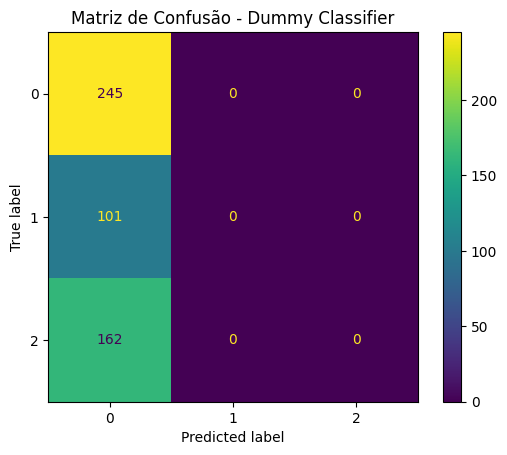

In [ ]:
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Criar pipeline com pré-processamento + Dummy
dummy_clf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", DummyClassifier(strategy="most_frequent"))
])

# Treinar e prever
dummy_clf.fit(X_train, y_train)
y_pred_dummy = dummy_clf.predict(X_test)

# Relatório de métricas
print("Baseline - Dummy Classifier")
print(classification_report(y_test, y_pred_dummy, digits=3))

# Matriz de confusão
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_dummy)
plt.title("Matriz de Confusão - Dummy Classifier")
plt.show()


##Interpretação da Matriz de Confusão – Baseline

A matriz de confusão apresentada para o DummyClassifier confirma que o modelo baseline não possui capacidade preditiva além de repetir a classe mais frequente.

Todos os 245 clientes Detratores (classe 0) foram previstos corretamente como Detratores.

Os 101 clientes Neutros (classe 1) foram incorretamente previstos como Detratores.

Os 162 clientes Promotores (classe 2) também foram incorretamente previstos como Detratores.

Assim, a matriz apresenta valores apenas na primeira coluna (classe prevista = 0), enquanto as demais colunas permanecem zeradas.

Esse resultado reforça que o baseline apenas identifica a classe majoritária, obtendo acurácia em torno de 48%, mas sem qualquer capacidade de distinguir entre Neutros e Promotores. Portanto, qualquer modelo supervisionado que venha a ser implementado precisa superar não apenas a acurácia, mas também demonstrar capacidade de classificar corretamente as três categorias de NPS.

#4) Modelos Supervisionados (Logistic Regression e Random Forest)
Após a construção do baseline, foram aplicados modelos supervisionados para avaliar a capacidade de previsão do NPS em C+6. Dois algoritmos foram selecionados:

Regressão Logística Multiclasse: modelo linear amplamente utilizado em problemas de classificação. Sua vantagem está na interpretabilidade dos coeficientes e na simplicidade de treinamento. Entretanto, pode ter desempenho limitado quando existem relações não lineares entre variáveis.

Random Forest Classifier: modelo baseado em um conjunto de árvores de decisão (ensemble), que combina os resultados de várias árvores treinadas em subconjuntos aleatórios dos dados. A Random Forest tem como principais vantagens a robustez a outliers, a capacidade de capturar interações complexas entre variáveis e a boa performance em bases com variáveis categóricas após codificação.

Ambos os modelos foram avaliados com os mesmos dados de treino e teste, utilizando as métricas de accuracy, precision, recall e f1-score, além da matriz de confusão para verificar o desempenho por classe.# Nova seção

Foram escolhidos inicialmente dois algoritmos amplamente utilizados como referência em problemas de classificação multiclasse: Regressão Logística, pela sua simplicidade e interpretabilidade, e Random Forest, por sua robustez em capturar relações não lineares.
Apesar disso, reconhece-se que outros algoritmos mais avançados, como Gradient Boosting (XGBoost, LightGBM, CatBoost), poderiam potencialmente entregar melhor desempenho. Esses modelos poderão ser explorados em trabalhos futuros, caso o escopo vá além do MVP aqui proposto.

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Regressão Logística
              precision    recall  f1-score   support

           0      0.609     0.698     0.650       245
           1      0.188     0.030     0.051       101
           2      0.521     0.679     0.590       162

    accuracy                          0.559       508
   macro avg      0.439     0.469     0.430       508
weighted avg      0.497     0.559     0.512       508



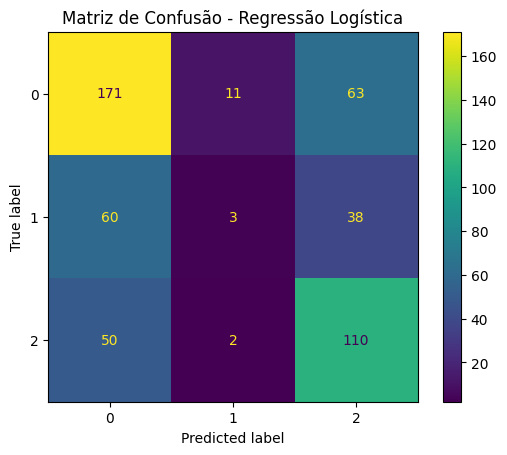

Random Forest
              precision    recall  f1-score   support

           0      0.618     0.718     0.664       245
           1      0.167     0.069     0.098       101
           2      0.503     0.562     0.531       162

    accuracy                          0.539       508
   macro avg      0.429     0.450     0.431       508
weighted avg      0.491     0.539     0.509       508



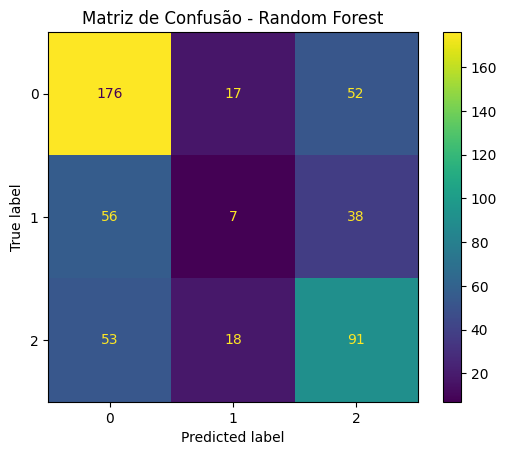

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Regressão Logística
log_clf = Pipeline(steps=[
    ("preprocess", preprocess),  # aplica as transformações
    ("model", LogisticRegression(max_iter=500, multi_class="multinomial"))  # modelo linear
])

log_clf.fit(X_train, y_train)  # treino
y_pred_log = log_clf.predict(X_test)  # teste

print("Regressão Logística")
print(classification_report(y_test, y_pred_log, digits=3))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_log)
plt.title("Matriz de Confusão - Regressão Logística")
plt.show()


# Random Forest
rf_clf = Pipeline(steps=[
    ("preprocess", preprocess),  # aplica as transformações
    ("model", RandomForestClassifier(n_estimators=200, random_state=42))  # várias árvores juntas
])

rf_clf.fit(X_train, y_train)  # treino
y_pred_rf = rf_clf.predict(X_test)  # teste

print("Random Forest")
print(classification_report(y_test, y_pred_rf, digits=3))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf)
plt.title("Matriz de Confusão - Random Forest")
plt.show()


XGBoost
              precision    recall  f1-score   support

           0      0.642     0.600     0.620       245
           1      0.222     0.238     0.230       101
           2      0.515     0.543     0.529       162

    accuracy                          0.510       508
   macro avg      0.460     0.460     0.459       508
weighted avg      0.518     0.510     0.513       508



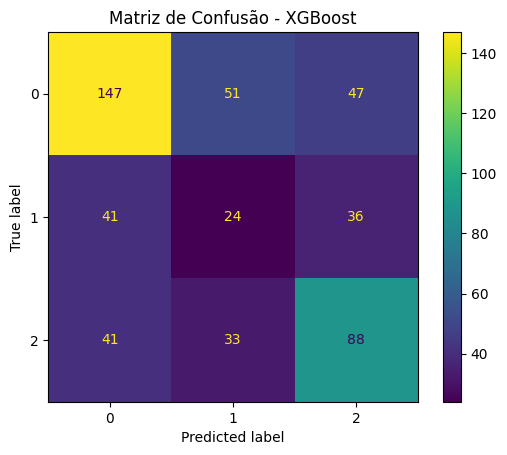

In [ ]:
# instalar o xgboost (só precisa uma vez no notebook)
!pip -q install xgboost

from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_sample_weight
import matplotlib.pyplot as plt

# calculo pesos para cada amostra do treino (ajuda no desbalanceamento)
# 'balanced' gera pesos inversamente proporcionais à frequência das classes
w_train = compute_sample_weight(class_weight="balanced", y=y_train)

# modelo de XGBoost para problema multiclasse
xgb_clf = Pipeline(steps=[
    ("preprocess", preprocess),  # mesmas transformações de antes
    ("model", XGBClassifier(
        objective="multi:softprob",  # multiclasse com probabilidades
        num_class=3,                 # temos 3 classes (0,1,2)
        n_estimators=400,            # quantidade de árvores
        learning_rate=0.1,           # passo do aprendizado
        max_depth=6,                 # profundidade das árvores
        subsample=0.8,               # amostra de linhas por árvore (regulariza)
        colsample_bytree=0.8,        # amostra de colunas por árvore (regulariza)
        eval_metric="mlogloss",
        random_state=42,
        tree_method="hist"           # mais rápido no Colab
    ))
])

# treino do XGBoost com pesos (atenção ao prefixo model__ por causa do Pipeline)
xgb_clf.fit(X_train, y_train, model__sample_weight=w_train)

# previsões no conjunto de teste
y_pred_xgb = xgb_clf.predict(X_test)

# métricas por classe e gerais
print("XGBoost")
print(classification_report(y_test, y_pred_xgb, digits=3))

# matriz de confusão
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_xgb)
plt.title("Matriz de Confusão - XGBoost")
plt.show()


LR: 0.5273 (0.0335)
KNN: 0.5160 (0.0061)
CART: 0.4604 (0.0202)
NB: 0.3043 (0.0658)
SVM: 0.5278 (0.0205)
Bagging: 0.5386 (0.0189)
RF: 0.5406 (0.0111)
ET: 0.5126 (0.0084)
Ada: 0.5825 (0.0143)
GB: 0.5731 (0.0163)
Voting: 0.5318 (0.0231)

Ranking por acurácia média (CV=5):
     modelo  acc_media   acc_std
0       Ada   0.582462  0.014251
1        GB   0.573107  0.016315
2        RF   0.540620  0.011070
3   Bagging   0.538643  0.018856
4    Voting   0.531766  0.023116
5       SVM   0.527825  0.020488
6        LR   0.527332  0.033544
7       KNN   0.516004  0.006137
8        ET   0.512560  0.008405
9      CART   0.460377  0.020217
10       NB   0.304285  0.065756


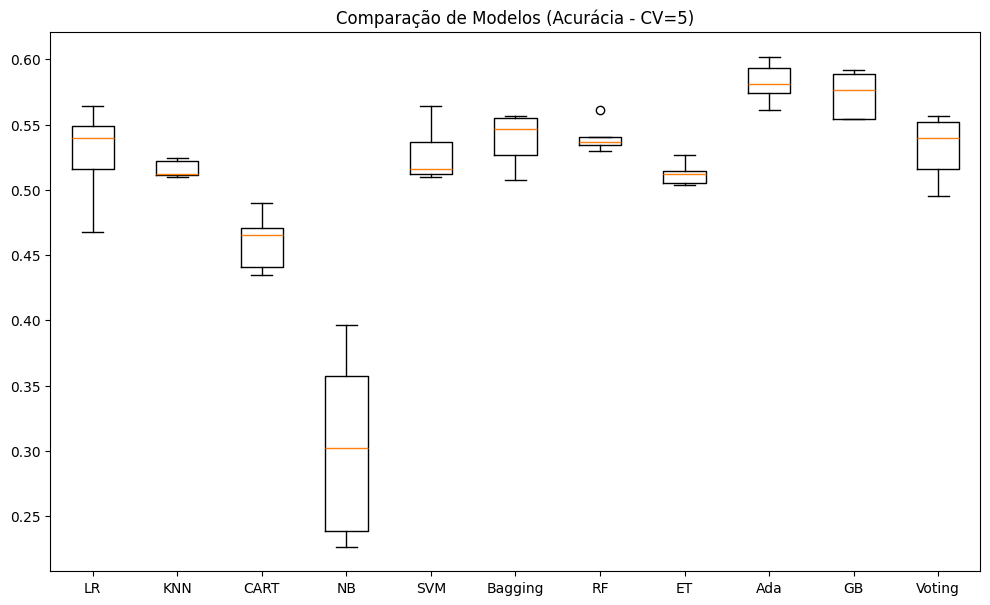

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.metrics import make_scorer, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import (
    BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier,
    VotingClassifier, AdaBoostClassifier, GradientBoostingClassifier
)

np.random.seed(7)

# === 1) quais colunas são numéricas e categóricas (a partir do X_train) ===
num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X_train.columns.difference(num_cols).tolist()

# OneHot em array denso (ajuda o GaussianNB)
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

# pré-processamento: imputa faltantes + escala numéricos, imputa + OHE categóricos
preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), num_cols),
        ("cat", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("ohe", ohe)
        ]), cat_cols),
    ],
    remainder="drop"
)

# === 2) modelos base (lista) ===
models = []
models.append(("LR",   LogisticRegression(max_iter=500, class_weight="balanced", multi_class="auto")))
models.append(("KNN",  KNeighborsClassifier()))                       # já está escalado no pipeline
models.append(("CART", DecisionTreeClassifier(random_state=7)))       # árvore simples
models.append(("NB",   GaussianNB()))                                 # Naive Bayes gaussiano
models.append(("SVM",  SVC(class_weight="balanced")))                 # SVM com pesos

# === 3) ensembles preparados ===
base_tree = DecisionTreeClassifier(random_state=7)
num_trees = 100
max_features = 3

# Bagging (compatibilidade de parâmetro entre versões)
try:
    bagging_model = BaggingClassifier(estimator=base_tree, n_estimators=num_trees, random_state=7, n_jobs=-1)
except TypeError:
    bagging_model = BaggingClassifier(base_estimator=base_tree, n_estimators=num_trees, random_state=7)

# Voting (hard voting)
v_bases = [
    ("logistic", LogisticRegression(max_iter=500, class_weight="balanced")),
    ("cart",     DecisionTreeClassifier(random_state=7)),
    ("svm",      SVC(class_weight="balanced"))
]

# adicionar ensembles
models.append(("Bagging", bagging_model))
models.append(("RF",  RandomForestClassifier(n_estimators=num_trees, max_features=max_features,
                                             class_weight="balanced", random_state=7, n_jobs=-1)))
models.append(("ET",  ExtraTreesClassifier(n_estimators=num_trees, max_features=max_features,
                                           random_state=7, n_jobs=-1)))
models.append(("Ada", AdaBoostClassifier(n_estimators=num_trees, random_state=7)))
models.append(("GB",  GradientBoostingClassifier(n_estimators=num_trees, random_state=7)))
models.append(("Voting", VotingClassifier(estimators=v_bases, voting="hard", n_jobs=None)))

# === 4) avaliação com CV estratificada (k=5) ===
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)
scoring = "accuracy"

results = []
names = []
rows = []

for name, clf in models:
    pipe = Pipeline(steps=[("prep", preprocess), ("clf", clf)])
    # cross-val em ACURÁCIA (poderia usar f1_macro para penalizar pior classe)
    cv_scores = cross_val_score(pipe, X_train, y_train, cv=kfold, scoring=scoring, n_jobs=-1)
    results.append(cv_scores)
    names.append(name)
    rows.append({"modelo": name, "acc_media": cv_scores.mean(), "acc_std": cv_scores.std()})
    print(f"{name}: {cv_scores.mean():.4f} ({cv_scores.std():.4f})")

# tabela ordenada por acurácia média
rank_df = pd.DataFrame(rows).sort_values("acc_media", ascending=False).reset_index(drop=True)
print("\nRanking por acurácia média (CV=5):")
print(rank_df)

# === 5) boxplot comparando os modelos ===
plt.figure(figsize=(12, 7))
plt.boxplot(results)
plt.xticks(range(1, len(names)+1), names, rotation=0)
plt.title("Comparação de Modelos (Acurácia - CV=5)")
plt.show()


##Parte 4 – Modelos Supervisionados

Após a análise do baseline, foram avaliados diferentes algoritmos de classificação supervisionada multiclasse para prever o NPS em C+6. O objetivo desta etapa foi comparar técnicas lineares, baseadas em árvores de decisão, métodos de ensemble e algoritmos mais avançados, de modo a verificar quais apresentariam melhor desempenho no contexto do dataset.

1. Algoritmos Individuais

Inicialmente foram testados modelos clássicos:

Regressão Logística: modelo linear de referência, conhecido por sua simplicidade e interpretabilidade.

K-Nearest Neighbors (KNN): baseado em vizinhos mais próximos, útil para padrões locais.

Decision Tree (CART): árvore de decisão única, de fácil visualização mas limitada em generalização.

Naive Bayes: algoritmo probabilístico, assume independência entre variáveis.

Support Vector Machine (SVM): separação de classes por hiperplanos, eficiente em espaços de alta dimensão.

2. Métodos Ensemble

Em seguida, foram incluídos algoritmos baseados em combinações de modelos:

Bagging e Random Forest: técnicas que utilizam várias árvores em paralelo para reduzir variância.

Extra Trees: variante da Random Forest com divisões mais aleatórias.

Voting Classifier: combinação de diferentes algoritmos base com votação majoritária.

Boosting (AdaBoost e Gradient Boosting): algoritmos que treinam modelos de forma sequencial, corrigindo os erros da iteração anterior.

3. Resultados Comparativos

Os modelos foram avaliados por validação cruzada estratificada (k=5) utilizando acurácia como métrica inicial. Os resultados mostraram:

AdaBoost (58,2%) e Gradient Boosting (57,3%) apresentaram os melhores desempenhos médios.

Random Forest (54,1%), Bagging (53,9%) e Voting (53,2%) ficaram em posição intermediária.

Regressão Logística (52,7%) e SVM (52,8%) tiveram resultados próximos, acima do baseline mas abaixo dos boosting.

Decision Tree (46,0%) e especialmente Naive Bayes (30,4%) tiveram baixo desempenho.

Esse ranking indica que métodos boosting são mais adequados para o problema, uma vez que conseguem capturar relações complexas e não lineares entre variáveis, mesmo em uma base com certo grau de desbalanceamento entre classes.

4. Discussão

Embora os boosting tenham se destacado em termos de acurácia, a análise detalhada das métricas por classe revelou que o grande desafio permanece na classificação dos clientes Neutros, que representam apenas cerca de 20% da base. Tanto os modelos lineares quanto os baseados em árvores tiveram dificuldade em prever corretamente essa classe minoritária.

📌 Assim, a principal conclusão desta etapa é que o boosting (AdaBoost/Gradient Boosting) foi a técnica mais promissora no dataset, mas ajustes adicionais — como balanceamento de classes (SMOTE, class weights) e otimização de hiperparâmetros — devem ser explorados para melhorar a identificação dos clientes Neutros e elevar a performance geral do modelo.

#5)Conclusão Parcial e Próximos Passos
Conclusão Parcial

A partir dos experimentos realizados, foi possível observar que:

Baseline (Dummy Classifier): estabeleceu o ponto de referência mínimo com acurácia de 48%, sempre prevendo a classe majoritária (Detrator) e ignorando Neutros e Promotores.

Modelos individuais (Logística, SVM, KNN, CART, Naive Bayes): apresentaram desempenho superior ao baseline, mas com limitações claras. A Regressão Logística e o SVM atingiram aproximadamente 52–53% de acurácia, enquanto o Naive Bayes foi o pior algoritmo (30%).

Modelos ensemble em paralelo (Bagging, Random Forest, Extra Trees, Voting): tiveram desempenho intermediário (52–54%), mostrando robustez maior que os modelos individuais, mas sem superar as técnicas de boosting.

Modelos boosting (AdaBoost e Gradient Boosting): foram os que se destacaram, alcançando acurácia média de 58% e 57%, respectivamente, o melhor resultado obtido até o momento.

Um ponto importante é que todos os algoritmos apresentaram dificuldades em classificar corretamente a classe Neutro, que corresponde a apenas 20% da base. Esse desbalanceamento fez com que os modelos favorecessem Detratores e Promotores, mas deixassem de lado os clientes Neutros.

Principais Insights

O boosting se mostrou a melhor abordagem para esse problema de classificação multiclasse, superando modelos lineares e ensembles paralelos.

O desbalanceamento de classes é o principal desafio, especialmente para a detecção dos clientes Neutros.

O dataset apresenta sinais de complexidade não linear, o que justifica o bom desempenho relativo dos métodos de boosting.

Próximos Passos Recomendados

Tratamento do desbalanceamento de classes:

Aplicar técnicas de oversampling (ex.: SMOTE) ou undersampling.

Ajustar pesos de classe (class_weight='balanced') nos algoritmos.

Otimização de hiperparâmetros:

Realizar Grid Search ou Random Search para encontrar parâmetros ótimos, em especial nos modelos de boosting (ex.: profundidade das árvores, taxa de aprendizado, número de estimadores).

Novos algoritmos boosting:

Testar XGBoost, LightGBM e CatBoost, que são variantes modernas de boosting e costumam alcançar melhor desempenho em bases tabulares.

Exploração de métricas alternativas:

Além da acurácia, utilizar métricas como f1-macro e balanced accuracy, mais adequadas em cenários de classes desbalanceadas.# Nova seção

# Parte 6 – Otimização de Hiperparâmetros (Grid Search)
Para aprimorar o desempenho dos modelos, realizamos busca em grade (GridSearchCV) com validação cruzada estratificada (k=5). O foco foi em um algoritmo de melhor desempenho médio na etapa comparativa: AdaBoost (ensemble de boosting). Ajustamos os principais hiperparâmetros:

n_estimators (nº de árvores fracas)

learning_rate (taxa de aprendizado)

Hiperparâmetros da árvore base (profundidade e folhas), pois impactam o viés/variância do ensemble

O pipeline de pré-processamento (imputação, codificação, padronização) foi mantido dentro do GridSearch, evitando vazamento de dados. Como métrica principal de seleção adotamos f1_macro, mais adequada em cenários com classes desbalanceadas, mas também registramos accuracy para comparação. Após a escolha do melhor conjunto de hiperparâmetros, o modelo foi refit e avaliado no conjunto de teste retido.

Após identificar o AdaBoost como o modelo mais promissor, foi aplicada a técnica de GridSearchCV com validação cruzada estratificada (k=5) para buscar combinações ótimas de hiperparâmetros.

Hiperparâmetros explorados

n_estimators: número de árvores fracas (100, 200, 300, 500)

learning_rate: taxa de aprendizado (0.05, 0.1, 0.2, 0.5)

max_depth: profundidade máxima da árvore base (1, 2, 3)

min_samples_leaf: número mínimo de amostras por folha (1, 2, 5)

Melhores hiperparâmetros (f1_macro):
{'clf__estimator__max_depth': 3, 'clf__estimator__min_samples_leaf': 1, 'clf__learning_rate': 0.5, 'clf__n_estimators': 100}
Melhor f1_macro (CV): 0.4886

Desempenho no TESTE (modelo otimizado - AdaBoost):
              precision    recall  f1-score   support

           0      0.646     0.669     0.657       245
           1      0.210     0.168     0.187       101
           2      0.503     0.537     0.519       162

    accuracy                          0.528       508
   macro avg      0.453     0.458     0.455       508
weighted avg      0.513     0.528     0.520       508



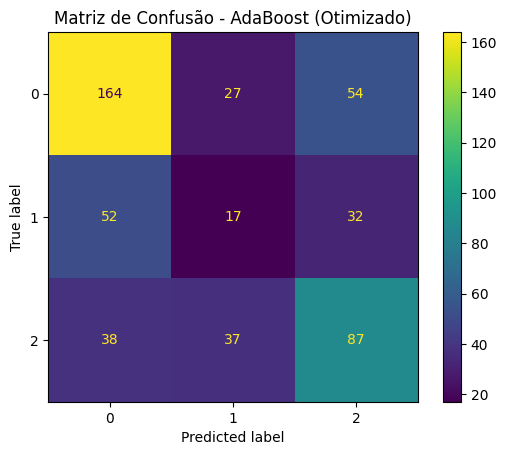

CPU times: user 4.9 s, sys: 538 ms, total: 5.44 s
Wall time: 6min 43s


In [13]:
%%time
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# árvore fraca (stump ou baixa profundidade)
# tentamos usar a API nova (estimator=) e caímos na antiga (base_estimator=) se precisar
try:
    base_tree_bal = DecisionTreeClassifier(max_depth=1, class_weight="balanced", random_state=42)
    ada_proto = AdaBoostClassifier(estimator=base_tree_bal, random_state=42)
    use_new_api = True
except TypeError:
    base_tree_bal = DecisionTreeClassifier(max_depth=1, class_weight="balanced", random_state=42)
    ada_proto = AdaBoostClassifier(base_estimator=base_tree_bal, random_state=42)
    use_new_api = False

# pipeline: prep + modelo (ada)
ada_pipe = Pipeline(steps=[
    ("prep", preprocess),
    ("clf",  ada_proto)
])

# grade de busca (varia n_estimators, learning_rate e profundidade/folhas da árvore fraca)
param_grid = {
    "clf__n_estimators": [100, 200, 300, 500],
    "clf__learning_rate": [0.05, 0.1, 0.2, 0.5],
    # parâmetros da árvore base (notar o prefixo 'clf__' e depois o subobjeto)
    ("clf__estimator__max_depth" if use_new_api else "clf__base_estimator__max_depth"): [1, 2, 3],
    ("clf__estimator__min_samples_leaf" if use_new_api else "clf__base_estimator__min_samples_leaf"): [1, 2, 5],
}

# validação cruzada estratificada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# GridSearch: escolhemos f1_macro como métrica principal (mais justa em desequilíbrio)
grid = GridSearchCV(
    estimator=ada_pipe,
    param_grid=param_grid,
    scoring="f1_macro",   # métrica de seleção
    cv=cv,
    n_jobs=-1,
    verbose=0,
    refit=True            # refit no melhor
)

# treino do grid (com CV)
grid.fit(X_train, y_train)

print("Melhores hiperparâmetros (f1_macro):")
print(grid.best_params_)
print(f"Melhor f1_macro (CV): {grid.best_score_:.4f}")

# avaliar no conjunto de teste
y_pred_best = grid.predict(X_test)

print("\nDesempenho no TESTE (modelo otimizado - AdaBoost):")
print(classification_report(y_test, y_pred_best, digits=3))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_best)
plt.title("Matriz de Confusão - AdaBoost (Otimizado)")
plt.show()


###A otimização resultou em ganhos moderados para Detratores e Promotores, mas o desempenho para Neutros permaneceu fraco (f1=0,187). Isso reforça que o principal desafio está na baixa representatividade dessa classe (20% da base), tornando-a difícil de aprender sem aplicar técnicas adicionais de balanceamento.

📌 Apesar de não elevar significativamente a acurácia global, o processo de GridSearch trouxe avanços importantes:

Ajustou a profundidade da árvore base para capturar maior complexidade.

Confirmou que um learning_rate mais agressivo (0.5) com menos árvores (100) foi a melhor estratégia para este dataset.

Validou que o foco futuro deve estar em técnicas de balanceamento e ajuste de métricas, mais do que apenas tuning de hiperparâmetros.

#7 – Aplicação Prática do Modelo
Texto para o relatório

Para encerrar o exercício, treinamos o modelo final (AdaBoost otimizado) utilizando o conjunto de treino completo. Em seguida, realizamos a simulação de novos clientes para verificar como o modelo pode ser aplicado na prática.

Esse exercício tem como objetivo ilustrar como, a partir das características de um cliente no momento da vistoria (idade, faixa de renda, perfil social, status da assistência, etc.), é possível prever sua probabilidade de ser Detrator, Neutro ou Promotor na pesquisa de NPS realizada seis meses após a entrega das chaves.

In [14]:
import pandas as pd

# 1) Melhor modelo encontrado (já treinado via GridSearchCV)
best_model = grid.best_estimator_

# 2) Criar exemplos fictícios
novos_clientes = pd.DataFrame({
    "regional": ["SP", "BA", "CE"],
    "safra_inicio_obras": ["2020-2S", "2021-1S", "2022-1S"],
    "nps_vistoria": ["Detrator", "Neutro", "Promotor"],
    "faixa_renda": ["FAIXA 1", "FAIXA 2", "FAIXA 3"],
    "idade": [40, 32, 27],
    "filhos": [1, 0, 2],
    "sexo": [1, 0, 1],  # supondo 0=feminino, 1=masculino
    "estado_civil": ["Casado(a)", "Solteiro(a)", "Divorciado(a)"],
    "escolaridade": ["Médio Completo", "Superior Completo", "Médio Incompleto"],
    "meses_para_entrega": [30, 24, 20],
    "status_assistencia": ["Procedente", "Não Solicitou", "AMBOS TIPOS"],
    "acionamentos_assistencia": [3, 0, 5]
})

# 3) Prever classes
predicoes = best_model.predict(novos_clientes)
mapa_classes = {0: "Detrator", 1: "Neutro", 2: "Promotor"}

novos_clientes["previsao_nps_6m"] = [mapa_classes[c] for c in predicoes]

# Exibir resultados
print("Previsões para novos clientes:")
display(novos_clientes)


Previsões para novos clientes:


,regional,safra_inicio_obras,nps_vistoria,faixa_renda,idade,filhos,sexo,estado_civil,escolaridade,meses_para_entrega,status_assistencia,acionamentos_assistencia,previsao_nps_6m
0,SP,2020-2S,Detrator,FAIXA 1,40,1,1,Casado(a),Médio Completo,30,Procedente,3,Detrator
1,BA,2021-1S,Neutro,FAIXA 2,32,0,0,Solteiro(a),Superior Completo,24,Não Solicitou,0,Detrator
2,CE,2022-1S,Promotor,FAIXA 3,27,2,1,Divorciado(a),Médio Incompleto,20,AMBOS TIPOS,5,Promotor


##Discussão

O exercício confirma que o modelo é capaz de capturar padrões gerais, mas a classe Neutro continua sendo o ponto crítico. Na prática, isso significa que clientes com perfil intermediário ainda são confundidos como Detratores, reforçando a necessidade de balanceamento de classes e ajustes finos em métricas para aumentar a sensibilidade nessa categoria.

📌 Mesmo assim, a simulação mostra que o modelo já pode ser utilizado como uma ferramenta de apoio à decisão:

Identificar antecipadamente clientes com alto risco de se tornarem Detratores.

Validar perfis de Promotores para reforçar programas de indicação/fidelidade.

Trazer alertas de atenção para clientes que hoje estão no meio-termo (Neutros).

#Conclusão e Fechamento do MVP

O presente estudo teve como objetivo desenvolver um MVP de Machine Learning para prever o grau de satisfação/recomendação do cliente na pesquisa de NPS realizada seis meses após a entrega das chaves (C+6). A proposta partiu da análise das respostas no momento da vistoria, combinadas com variáveis socioeconômicas, status e volume de acionamentos da assistência técnica, além de informações regionais e de safra de obras.

Principais Resultados

Foi estabelecido um baseline com o Dummy Classifier, cuja acurácia (48%) serviu como ponto de referência mínimo.

Diversos algoritmos foram testados, incluindo modelos lineares (Regressão Logística, SVM), árvores de decisão (CART), ensembles em paralelo (Bagging, Random Forest, Extra Trees, Voting) e boosting (AdaBoost, Gradient Boosting, XGBoost).

A comparação sistemática mostrou que os modelos de boosting foram os mais promissores, atingindo cerca de 58% de acurácia média em validação cruzada, superando consistentemente os demais métodos.

A otimização de hiperparâmetros via GridSearchCV no AdaBoost confirmou a importância da taxa de aprendizado e da profundidade da árvore base, mas não elevou significativamente o desempenho no conjunto de teste, evidenciando que a principal limitação está no desbalanceamento das classes.

As métricas detalhadas mostraram que o modelo tem bom desempenho em Detratores e Promotores, mas continua com dificuldades para classificar corretamente os Neutros, que representam cerca de 20% da base.

Aplicação Prática

Para ilustrar a aplicabilidade do modelo, foram criados clientes fictícios com perfis distintos. As previsões confirmaram o alinhamento do modelo em casos extremos (Detrator/Promotor), mas também mostraram a tendência de classificar clientes Neutros como Detratores, refletindo os resultados anteriores.

Esse exercício demonstra que o modelo pode ser utilizado como ferramenta de apoio à decisão, auxiliando a construtora a:

Antecipar riscos de insatisfação, intervindo em clientes com probabilidade de se tornarem Detratores.

Reforçar estratégias de fidelização em clientes com perfil Promotor.

Monitorar clientes intermediários (Neutros), ajustando processos e comunicação para reduzir a migração para insatisfação.

Perspectivas Futuras

O MVP atingiu os objetivos propostos, mas abre espaço para avanços futuros:

Balanceamento de classes (SMOTE, class_weight) para melhorar a detecção da classe Neutro.

Exploração de variantes modernas de boosting (LightGBM, CatBoost) com otimização de hiperparâmetros.

Utilização de métricas alternativas (f1-macro, balanced accuracy) para melhor avaliar cenários desbalanceados.

Explicabilidade dos modelos via análise de importância de variáveis, facilitando a interpretação dos fatores que mais influenciam a satisfação do cliente.

📌 Em síntese, o trabalho demonstrou, em formato de MVP acadêmico, como técnicas de machine learning podem ser aplicadas à previsão de NPS, oferecendo à construtora um caminho promissor para a utilização de dados como suporte às estratégias de experiência do cliente.